<a href="https://colab.research.google.com/github/leahnagy/yoga_pose_classifier/blob/main/code/MoveNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MoveNet Practice
## Visualization Libraries & Imports

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
! pwd

/content


In [ ]:
!pip install -q opencv-python

In [ ]:
import csv
import cv2 
import itertools
import numpy as np
import pandas as pd
import os
import sys
import tempfile
import tqdm

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
# Download model from TF Hub
!wget -q -O movenet_thunder.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
!git clone https://github.com/tensorflow/examples.git
pose_sample_rpi_path = os.path.join(os.getcwd(), 'examples/lite/examples/pose_estimation/raspberry_pi')
sys.path.append(pose_sample_rpi_path)

Cloning into 'examples'...
remote: Enumerating objects: 21931, done.
remote: Counting objects: 100% (591/591), done.
remote: Compressing objects: 100% (351/351), done.
remote: Total 21931 (delta 234), reused 454 (delta 162), pack-reused 21340
Receiving objects: 100% (21931/21931), 37.45 MiB | 30.53 MiB/s, done.
Resolving deltas: 100% (11995/11995), done.


In [ ]:
# Load MoveNet Thunder model
import utils
from data import BodyPart
from ml import Movenet
movenet = Movenet('movenet_thunder')

In [ ]:
# Define function to run pose estimation using MoveNet Thunder
def detect(input_tensor, inference_count=3):
  """Runs detection on an input image.

  Args:
    input_tensor: A [height, width, 3] tensor of type tf.float32.
        Note that height and width can be anything since the image 
        will be immediately resized according to the needs of the 
        model within this function.
    inference_count: Number of times the model should run repeatedly
        on the same input image to improve detection accuracy.
      
  Returns:
    A person entity detected by the MoveNet.SinglePose
  """
  image_height, image_width, channel = input_tensor.shape

  # Detect pose using the full input image
  movenet.detect(input_tensor.numpy(), reset_crop_region=True)

  # Repeatedly using previous detection result to identify the
  # region of interest and only cropping that region to improve
  # detection accuracy
  for _ in range(inference_count - 1):
    person = movenet.detect(input_tensor.numpy(),
                            reset_crop_region=False)
    
  return person

In [ ]:
# title functions to visualize the pose estimation results

def draw_prediction_on_image(
    image, person, crop_region=None, close_figure=True,
    keep_input_size=False):
  """Draws the keypoint predictions on image.

  Args:
  image: A numpy array with shape [height, width, channel] representing 
      the pixel values of the input image.
  person: A person entity returned from the MoveNet.SinglePose model.
  close_figure: Whether to close the plt figure after the function returns.
  keep_input_size: Whether to keep the size of the input image.

  Returns:
    A numpy array with shape [out_height, out_width, channel] representing
    the image overlaid with keypoint predictions. 
  """
  # Draw the detection result on top of the image. 
  image_np = utils.visualize(image, [person])

  # Plot the image with detection results.
  height, width, channel = image.shape
  aspect_ratio = float(width) / height 
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  im = ax.imshow(image_np)

  if close_figure:
    plt.close(fig)

  if not keep_input_size:
    image_np = utils.keep_aspect_ratio_resizer(image_np, (512, 512))

  return image_np

In [ ]:
# Load images, detect pose landmarks and save to CSV 
class MoveNetPreprocessor(object):
  """Helper class to preprocess pose sample images for classification."""
  
  def __init__(self,
               images_in_folder,
               images_out_folder,
               csvs_out_path):
    """Creates a preprocessor to detect pose from images and save as csv.

    Args:
      images_in_folder: Path to folder with input images. It should follow 
          this structure:
          yoga_poses
          |__ downdog
              |______ 00000128.jpg
              |______ 00000181.bmp
              |______ ...
          |__ goddess
              |______ 00000243.jpg
              |______ 00000306.jpg
              |______ ...
          ...
      images_out_folder: Path to write the images overlay with detected
          landmarks. These images are useful when you need to debug 
          accuracy issues.
      csvs_out_path: Path to write the CSV containing the detected landmark
          coordinates and label of each image than can be used to train a 
          pose classification model. 
    """
    self._images_in_folder = images_in_folder
    self._images_out_folder = images_out_folder
    self._csvs_out_path = csvs_out_path
    self._messages = []

    # Create a temp dir to store the pose CSVs per class
    self._csvs_out_folder_per_class = tempfile.mkdtemp()

    # Get list of pose classes and print image statistics 
    self._pose_class_names = sorted(
        [n for n in os.listdir(self._images_in_folder) if not \
         n.startswith('.')])
    
  def process(self, per_pose_class_limit=None, detection_threshold=0.1):
    """Preprocesses images in the given folder.
    Args:
      per_pose_class_limit: No. images to load.
      detection_threshold: Only keep images with all landmark confidence
          score above this threshold
    """
    # Loop through the classes and preprocess its images
    for pose_class_name in self._pose_class_names:
      print('Preprocessing', pose_class_name, file=sys.stderr)

      # Paths for the pose class
      images_in_folder = os.path.join(self._images_in_folder, pose_class_name)
      images_out_folder = os.path.join(self._images_out_folder, pose_class_name)
      csv_out_path = os.path.join(self._csvs_out_folder_per_class, 
                                  pose_class_name + '.csv')
      
      # create images_out_folder if it does not exist
      if not os.path.exists(images_out_folder):
        os.makedirs(images_out_folder)

      # Detect landmarks in each image and write it to a CSV file
      with open(csv_out_path, 'w') as csv_out_file:
        csv_out_writer = csv.writer(csv_out_file, 
                                    delimiter=',',
                                    quoting=csv.QUOTE_MINIMAL)
        # Get list of images
        image_names = sorted(
            [n for n in os.listdir(images_in_folder) if not n.startswith('.')])
        if per_pose_class_limit is not None:
          image_names = image_names[:per_pose_class_limit]

        valid_image_count = 0

        # Detect pose landmarks from each image
        for image_name in tqdm.tqdm(image_names):
          image_path = os.path.join(images_in_folder, image_name)

          try:
            image = tf.io.read_file(image_path)
            image = tf.io.decode_jpeg(image)
          except:
            self._messages.append('Skipped ' + image_path + '. Invalid image.')
            continue
          else:
            image = tf.io.read_file(image_path)
            image = tf.io.decode_jpeg(image)
            image_height, image_width, channel = image.shape

          # Skip images that aren't RGB. Requires RGB images.
          if channel != 3:
            self._messages.append('Skipped ' + image_path + 
                                  '. Image isn\'t in RGB format.')
            continue
          person = detect(image)

          # Save landmarks if all landmarks were detected 
          min_landmarks_score = min(
              [keypoint.score for keypoint in person.keypoints])
          should_keep_image = min_landmarks_score >= detection_threshold
          if not should_keep_image:
            self._messages.append('Skipped ' + image_path + 
                                  '. No pose was confidentally detected.')
            continue
          
          valid_image_count += 1

          # Draw the prediction result on top of the image
          output_overlay = draw_prediction_on_image(
              image.numpy().astype(np.uint8), person, 
              close_figure=True, keep_input_size=True)
          
          # Write detection result into an image file
          output_frame = cv2.cvtColor(output_overlay, cv2.COLOR_RGB2BGR)
          cv2.imwrite(os.path.join(images_out_folder, image_name), output_frame)

          # Get landmarks and scale it to the same size as the input image
          pose_landmarks = np.array(
              [[keypoint.coordinate.x, keypoint.coordinate.y, keypoint.score]
              for keypoint in person.keypoints],
              dtype=np.float32)
          
          # Write landmark coordinates to its per-class CSV file
          coordinates = pose_landmarks.flatten().astype(str).tolist()
          csv_out_writer.writerow([image_name] + coordinates)

        if not valid_image_count:
          raise RuntimeError(
              'No valid images for the "{}" class.'
              .format(pose_class_name))
    
    # Print the error message collected during preprocessing 
    print('\n'.join(self._messages))

    # Combine all per-class CSVs into a single output file
    all_landmarks_df = self._all_landmarks_as_dataframe()
    all_landmarks_df.to_csv(self._csvs_out_path, index=False)

  def class_names(self):
    """List of classes found in the training dataset."""
    return self._pose_class_names

  def _all_landmarks_as_dataframe(self):
    """Merge all per-class CSVs into a single dataframe."""
    total_df = None
    for class_index, class_name in enumerate(self._pose_class_names):
      csv_out_path = os.path.join(self._csvs_out_folder_per_class,
                                  class_name + '.csv')
      per_class_df = pd.read_csv(csv_out_path, header=None)

      # Add the labels
      per_class_df['class_no'] = [class_index]*len(per_class_df)
      per_class_df['class_name'] = [class_name]*len(per_class_df)

      # Append the folder name to the filename column
      per_class_df[per_class_df.columns[0]] = (os.path.join(class_name, '')
      + per_class_df[per_class_df.columns[0]].astype(str))

      if total_df is None:
        # For the first class, assign its data to the total dataframe
        total_df = per_class_df
      else:
        # Concatenate each class's data into the total dataframe
        total_df = pd.concat([total_df, per_class_df], axis=0)

    list_name = [[bodypart.name + '_x', bodypart.name + '_y', 
                  bodypart.name + '_score'] for bodypart in BodyPart]

    header_name = []
    for columns_name in list_name:
      header_name += columns_name
    header_name = ['file_name'] + header_name 
    header_map = {total_df.columns[i]: header_name[i]
                  for i in range(len(header_name))}

    total_df.rename(header_map, axis=1, inplace=True)

    return total_df     

--2022-08-04 20:31:25--  https://cdn.pixabay.com/photo/2017/03/03/17/30/yoga-2114512_960_720.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 104.18.37.244, 172.64.150.12, 2606:4700:4400::ac40:960c, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|104.18.37.244|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17652 (17K) [image/jpeg]
Saving to: ‘/tmp/image.jpeg’

/tmp/image.jpeg     100%[===================>]  17.24K  --.-KB/s    in 0s      

2022-08-04 20:31:25 (90.1 MB/s) - ‘/tmp/image.jpeg’ saved [17652/17652]



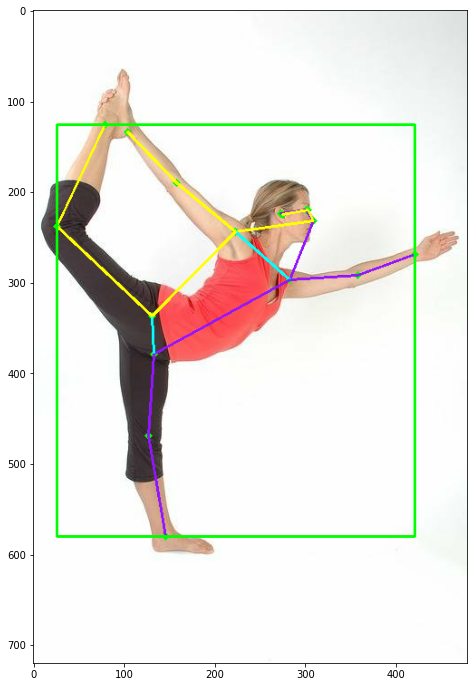

In [ ]:
# Code snippet to try out the MoveNet pose estimation logic
# You can download an image from the internet, run this code, and plot
# Useful for debugging

test_image_url = "https://cdn.pixabay.com/photo/2017/03/03/17/30/yoga-2114512_960_720.jpg" #@param {type:"string"}
!wget -O /tmp/image.jpeg {test_image_url}

if len(test_image_url):
  image = tf.io.read_file('/tmp/image.jpeg')
  image = tf.io.decode_jpeg(image)
  person = detect(image)
  _ = draw_prediction_on_image(image.numpy(), person, crop_region=None, 
                               close_figure=False, keep_input_size=True)

In [ ]:
dataset_in = "/content/gdrive/MyDrive/Yoga Pose Classification Dataset/TRAIN/"
dataset_out = '/content/gdrive/MyDrive/Yoga Pose Classification Dataset/'
# split_into_train_valid(dataset_in, dataset_out, valid_split=0.2)

## Preprocess the TRAIN dataset

In [ ]:
images_in_train_folder = "/content/gdrive/MyDrive/Yoga Pose Classification Dataset/TRAIN/"
images_out_train_folder = 'poses_images_out_train'
csvs_out_train_path = 'train_data.csv'

preprocessor = MoveNetPreprocessor(
    images_in_folder=images_in_train_folder,
    images_out_folder=images_out_train_folder,
    csvs_out_path=csvs_out_train_path,
)

preprocessor.process(per_pose_class_limit=None)

Preprocessing downdog
100%|██████████| 224/224 [11:43<00:00,  3.14s/it]
Preprocessing goddess
 68%|██████▊   | 125/184 [06:41<03:12,  3.27s/it]/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 184/184 [09:46<00:00,  3.19s/it]
Preprocessing plank
100%|██████████| 270/270 [14:05<00:00,  3.13s/it]
Preprocessing tree
100%|██████████| 162/162 [08:24<00:00,  3.11s/it]
Preprocessing warrior2
100%|██████████| 260/260 [13:55<00:00,  3.21s/it]

Skipped /content/gdrive/MyDrive/Yoga Pose Classification Dataset/TRAIN/downdog/00000147.jpg. No pose was confidentally detected.
Skipped /content/gdrive/MyDrive/Yoga Pose Classification Dataset/TRAIN/downdog/00000168.jpg. No pose was confidentally detected.
Skipped /content/gdrive/MyDrive/Yoga Pose Classification Dataset/TRAIN/downdog/00000188.png. Image isn't in RGB format.
Skipped /content/gdrive/MyDrive/Yoga Pose Classification Dataset/TRAIN/downdog/00000194.jpg. No pose was confidentally detected.
Skipped /content/gdrive/MyDrive/Yoga Pose Classification Dataset/TRAIN/downdog/00000212.png. Image isn't in RGB format.
Skipped /content/gdrive/MyDrive/Yoga Pose Classification Dataset/TRAIN/downdog/00000218.jpg. No pose was confidentally detected.
Skipped /content/gdrive/MyDrive/Yoga Pose Classification Dataset/TRAIN/downdog/00000220.jpg. No pose was confidentally detected.
Skipped /content/gdrive/MyDrive/Yoga Pose Classification Dataset/TRAIN/downdog/00000221.jpg. No pose was confidenta

## Preprocess the TEST dataset

In [ ]:
images_in_test_folder = "/content/gdrive/MyDrive/Yoga Pose Classification Dataset/TEST/"
images_out_test_folder = 'poses_images_out_test'
csvs_out_test_path = 'test_data.csv'

preprocessor = MoveNetPreprocessor(
    images_in_folder=images_in_test_folder,
    images_out_folder=images_out_test_folder,
    csvs_out_path=csvs_out_test_path,
)

preprocessor.process(per_pose_class_limit=None)

Preprocessing downdog
100%|██████████| 97/97 [05:27<00:00,  3.38s/it]
Preprocessing goddess
100%|██████████| 80/80 [04:38<00:00,  3.48s/it]
Preprocessing plank
100%|██████████| 115/115 [06:11<00:00,  3.23s/it]
Preprocessing tree
 86%|████████▌ | 59/69 [03:34<00:35,  3.50s/it]/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 69/69 [04:07<00:00,  3.58s/it]
Preprocessing warrior2
100%|██████████| 109/109 [05:54<00:00,  3.25s/it]

Skipped /content/gdrive/MyDrive/Yoga Pose Classification Dataset/TEST/downdog/00000010.png. Image isn't in RGB format.
Skipped /content/gdrive/MyDrive/Yoga Pose Classification Dataset/TEST/downdog/00000017.png. Image isn't in RGB format.
Skipped /content/gdrive/MyDrive/Yoga Pose Classification Dataset/TEST/downdog/00000035.jpg. No pose was confidentally detected.
Skipped /content/gdrive/MyDrive/Yoga Pose Classification Dataset/TEST/downdog/00000041.png. Image isn't in RGB format.
Skipped /content/gdrive/MyDrive/Yoga Pose Classification Dataset/TEST/downdog/00000042.jpg. No pose was confidentally detected.
Skipped /content/gdrive/MyDrive/Yoga Pose Classification Dataset/TEST/downdog/00000075.png. Image isn't in RGB format.
Skipped /content/gdrive/MyDrive/Yoga Pose Classification Dataset/TEST/downdog/00000080.jpg. No pose was confidentally detected.
Skipped /content/gdrive/MyDrive/Yoga Pose Classification Dataset/TEST/downdog/00000102.png. Image isn't in RGB format.
Skipped /content/gdri

## Train a Pose Classification Model
Model takes landmark coordinates as input and outputs the predicted labels

### Load and split datasets

In [ ]:
def load_pose_landmarks(csv_path):
  """Loads a CSV created by MoveNetPreprocessor.
  
  Returns:
    X: Detected landmark coordinates and scores of shape (N, 17 * 3)
    y: Ground truth labels of shape (N, label_count)
    classes: The list of all class names found in the dataset
    dataframe: The CSV loaded as a Pandas dataframe features (X) and ground
      truth labels (y) to use later to train a pose classification model.
  """

  # Load the CSV file
  dataframe = pd.read_csv(csv_path)
  df_to_process = dataframe.copy()

  # Drop the file_name columns as you don't need it during training.
  df_to_process.drop(columns=['file_name'], inplace=True)

  # Extract the list of class names
  classes = df_to_process.pop('class_name').unique()

  # Extract the labels
  y = df_to_process.pop('class_no')

  # Convert the input features and labels into the correct format for training.
  X = df_to_process.astype('float64')
  y = keras.utils.to_categorical(y)

  return X, y, classes, dataframe

In [ ]:
# Load the train data
X, y, class_names, _ = load_pose_landmarks(csvs_out_train_path)

# Split training data (X, y) into (X_train, y_train) and (X_val, y_val)
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.15)

In [ ]:
# Load the test data
X_test, y_test, _, df_test = load_pose_landmarks(csvs_out_test_path)

## Define functions to convert the pose landmarks to a pose embedding (a.k.a. feature vector) for pose classification <br>

Next, convert the landmark coordinates to a feature vector by:

1. Moving the pose center to the origin.
Scaling the pose so that the pose size becomes 1
2. Flattening these coordinates into a feature vector
3. Then use this feature vector to train a neural-network based pose classifier.



In [ ]:
def get_center_point(landmarks, left_bodypart, right_bodypart):
  """Calculates the center point of the two given landmarks."""

  left = tf.gather(landmarks, left_bodypart.value, axis=1)
  right = tf.gather(landmarks, right_bodypart.value, axis=1)
  center = left * 0.5 + right * 0.5
  return center


def get_pose_size(landmarks, torso_size_multiplier=2.5):
  """Calculates pose size.

  It is the maximum of two values:
    * Torso size multiplied by `torso_size_multiplier`
    * Maximum distance from pose center to any pose landmark
  """
  # Hips center
  hips_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)

  # Shoulders center
  shoulders_center = get_center_point(landmarks, BodyPart.LEFT_SHOULDER,
                                      BodyPart.RIGHT_SHOULDER)

  # Torso size as the minimum body size
  torso_size = tf.linalg.norm(shoulders_center - hips_center)

  # Pose center
  pose_center_new = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                     BodyPart.RIGHT_HIP)
  pose_center_new = tf.expand_dims(pose_center_new, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to
  # perform substraction
  pose_center_new = tf.broadcast_to(pose_center_new,
                                    [tf.size(landmarks) // (17*2), 17, 2])

  # Dist to pose center
  d = tf.gather(landmarks - pose_center_new, 0, axis=0,
                name="dist_to_pose_center")
  # Max dist to pose center
  max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))

  # Normalize scale
  pose_size = tf.maximum(torso_size * torso_size_multiplier, max_dist)

  return pose_size


def normalize_pose_landmarks(landmarks):
  """Normalizes the landmarks translation by moving the pose center to (0,0) and
  scaling it to a constant pose size.
  """
  # Move landmarks so that the pose center becomes (0,0)
  pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)
  pose_center = tf.expand_dims(pose_center, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to perform
  # substraction
  pose_center = tf.broadcast_to(pose_center, 
                                [tf.size(landmarks) // (17*2), 17, 2])
  landmarks = landmarks - pose_center

  # Scale the landmarks to a constant pose size
  pose_size = get_pose_size(landmarks)
  landmarks /= pose_size

  return landmarks


def landmarks_to_embedding(landmarks_and_scores):
  """Converts the input landmarks into a pose embedding."""
  # Reshape the flat input into a matrix with shape=(17, 3)
  reshaped_inputs = keras.layers.Reshape((17, 3))(landmarks_and_scores)

  # Normalize landmarks 2D
  landmarks = normalize_pose_landmarks(reshaped_inputs[:, :, :2])

  # Flatten the normalized landmark coordinates into a vector
  embedding = keras.layers.Flatten()(landmarks)

  return embedding

## Define a Keras model for pose classification

Our Keras model takes the detected pose landmarks, then calculates the pose embedding and predicts the pose class.

In [ ]:
# Define the model
inputs = tf.keras.Input(shape=(51))
embedding = landmarks_to_embedding(inputs)

layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 51)]         0           []                               
                                                                                                  
 reshape (Reshape)              (None, 17, 3)        0           ['input_1[0][0]']                
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 17, 2)       0           ['reshape[0][0]']                
 ingOpLambda)                                                                                     
                                                                                                  
 tf.compat.v1.gather (TFOpLambd  (None, 2)           0           ['tf.__operators__.getitem[0]

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
checkpoint_path = "weights.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                              patience=20)

# Start training
history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200
21/24 [=========================>....] - ETA: 0s - loss: 1.5794 - accuracy: 0.3333 
Epoch 1: val_accuracy improved from -inf to 0.69697, saving model to weights.best.hdf5
24/24 [==============================] - 1s 18ms/step - loss: 1.5758 - accuracy: 0.3414 - val_loss: 1.5345 - val_accuracy: 0.6970
Epoch 2/200
24/24 [==============================] - ETA: 0s - loss: 1.4899 - accuracy: 0.4866
Epoch 2: val_accuracy did not improve from 0.69697
24/24 [==============================] - 0s 4ms/step - loss: 1.4899 - accuracy: 0.4866 - val_loss: 1.4261 - val_accuracy: 0.6667
Epoch 3/200
 1/24 [>.............................] - ETA: 0s - loss: 1.5245 - accuracy: 0.3750
Epoch 3: val_accuracy did not improve from 0.69697
24/24 [==============================] - 0s 3ms/step - loss: 1.3647 - accuracy: 0.5726 - val_loss: 1.2550 - val_accuracy: 0.6667
Epoch 4/200
 1/24 [>.............................] - ETA: 0s - loss: 1.2532 - accuracy: 0.6250
Epoch 4: val_accuracy did not improve from

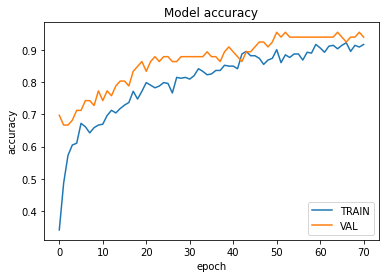

In [ ]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

In [ ]:
# Evaluate the model using the TEST dataset
loss, accuracy = model.evaluate(X_test, y_test)

14/14 [==============================] - 0s 2ms/step - loss: 0.2159 - accuracy: 0.9680


## Draw the confusion matrix to better understand the model performance

Confusion matrix, without normalization

Classification Report:
               precision    recall  f1-score   support

     downdog       1.00      1.00      1.00        87
     goddess       0.96      0.86      0.90        77
       plank       0.99      1.00      1.00       107
        tree       0.98      1.00      0.99        64
    warrior2       0.92      0.97      0.94       103

    accuracy                           0.97       438
   macro avg       0.97      0.97      0.97       438
weighted avg       0.97      0.97      0.97       438



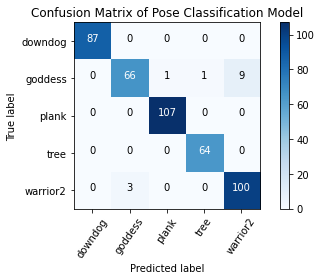

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """Plots the confusion matrix."""
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=55)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()

# Classify pose in the TEST dataset using the trained model
y_pred = model.predict(X_test)

# Convert the prediction result to class name
y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [class_names[i] for i in np.argmax(y_test, axis=1)]

# Plot the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm,
                      class_names,
                      title ='Confusion Matrix of Pose Classification Model')

# Print the classification report
print('\nClassification Report:\n', classification_report(y_true_label,
                                                          y_pred_label))

## Investigate incorrect predictions

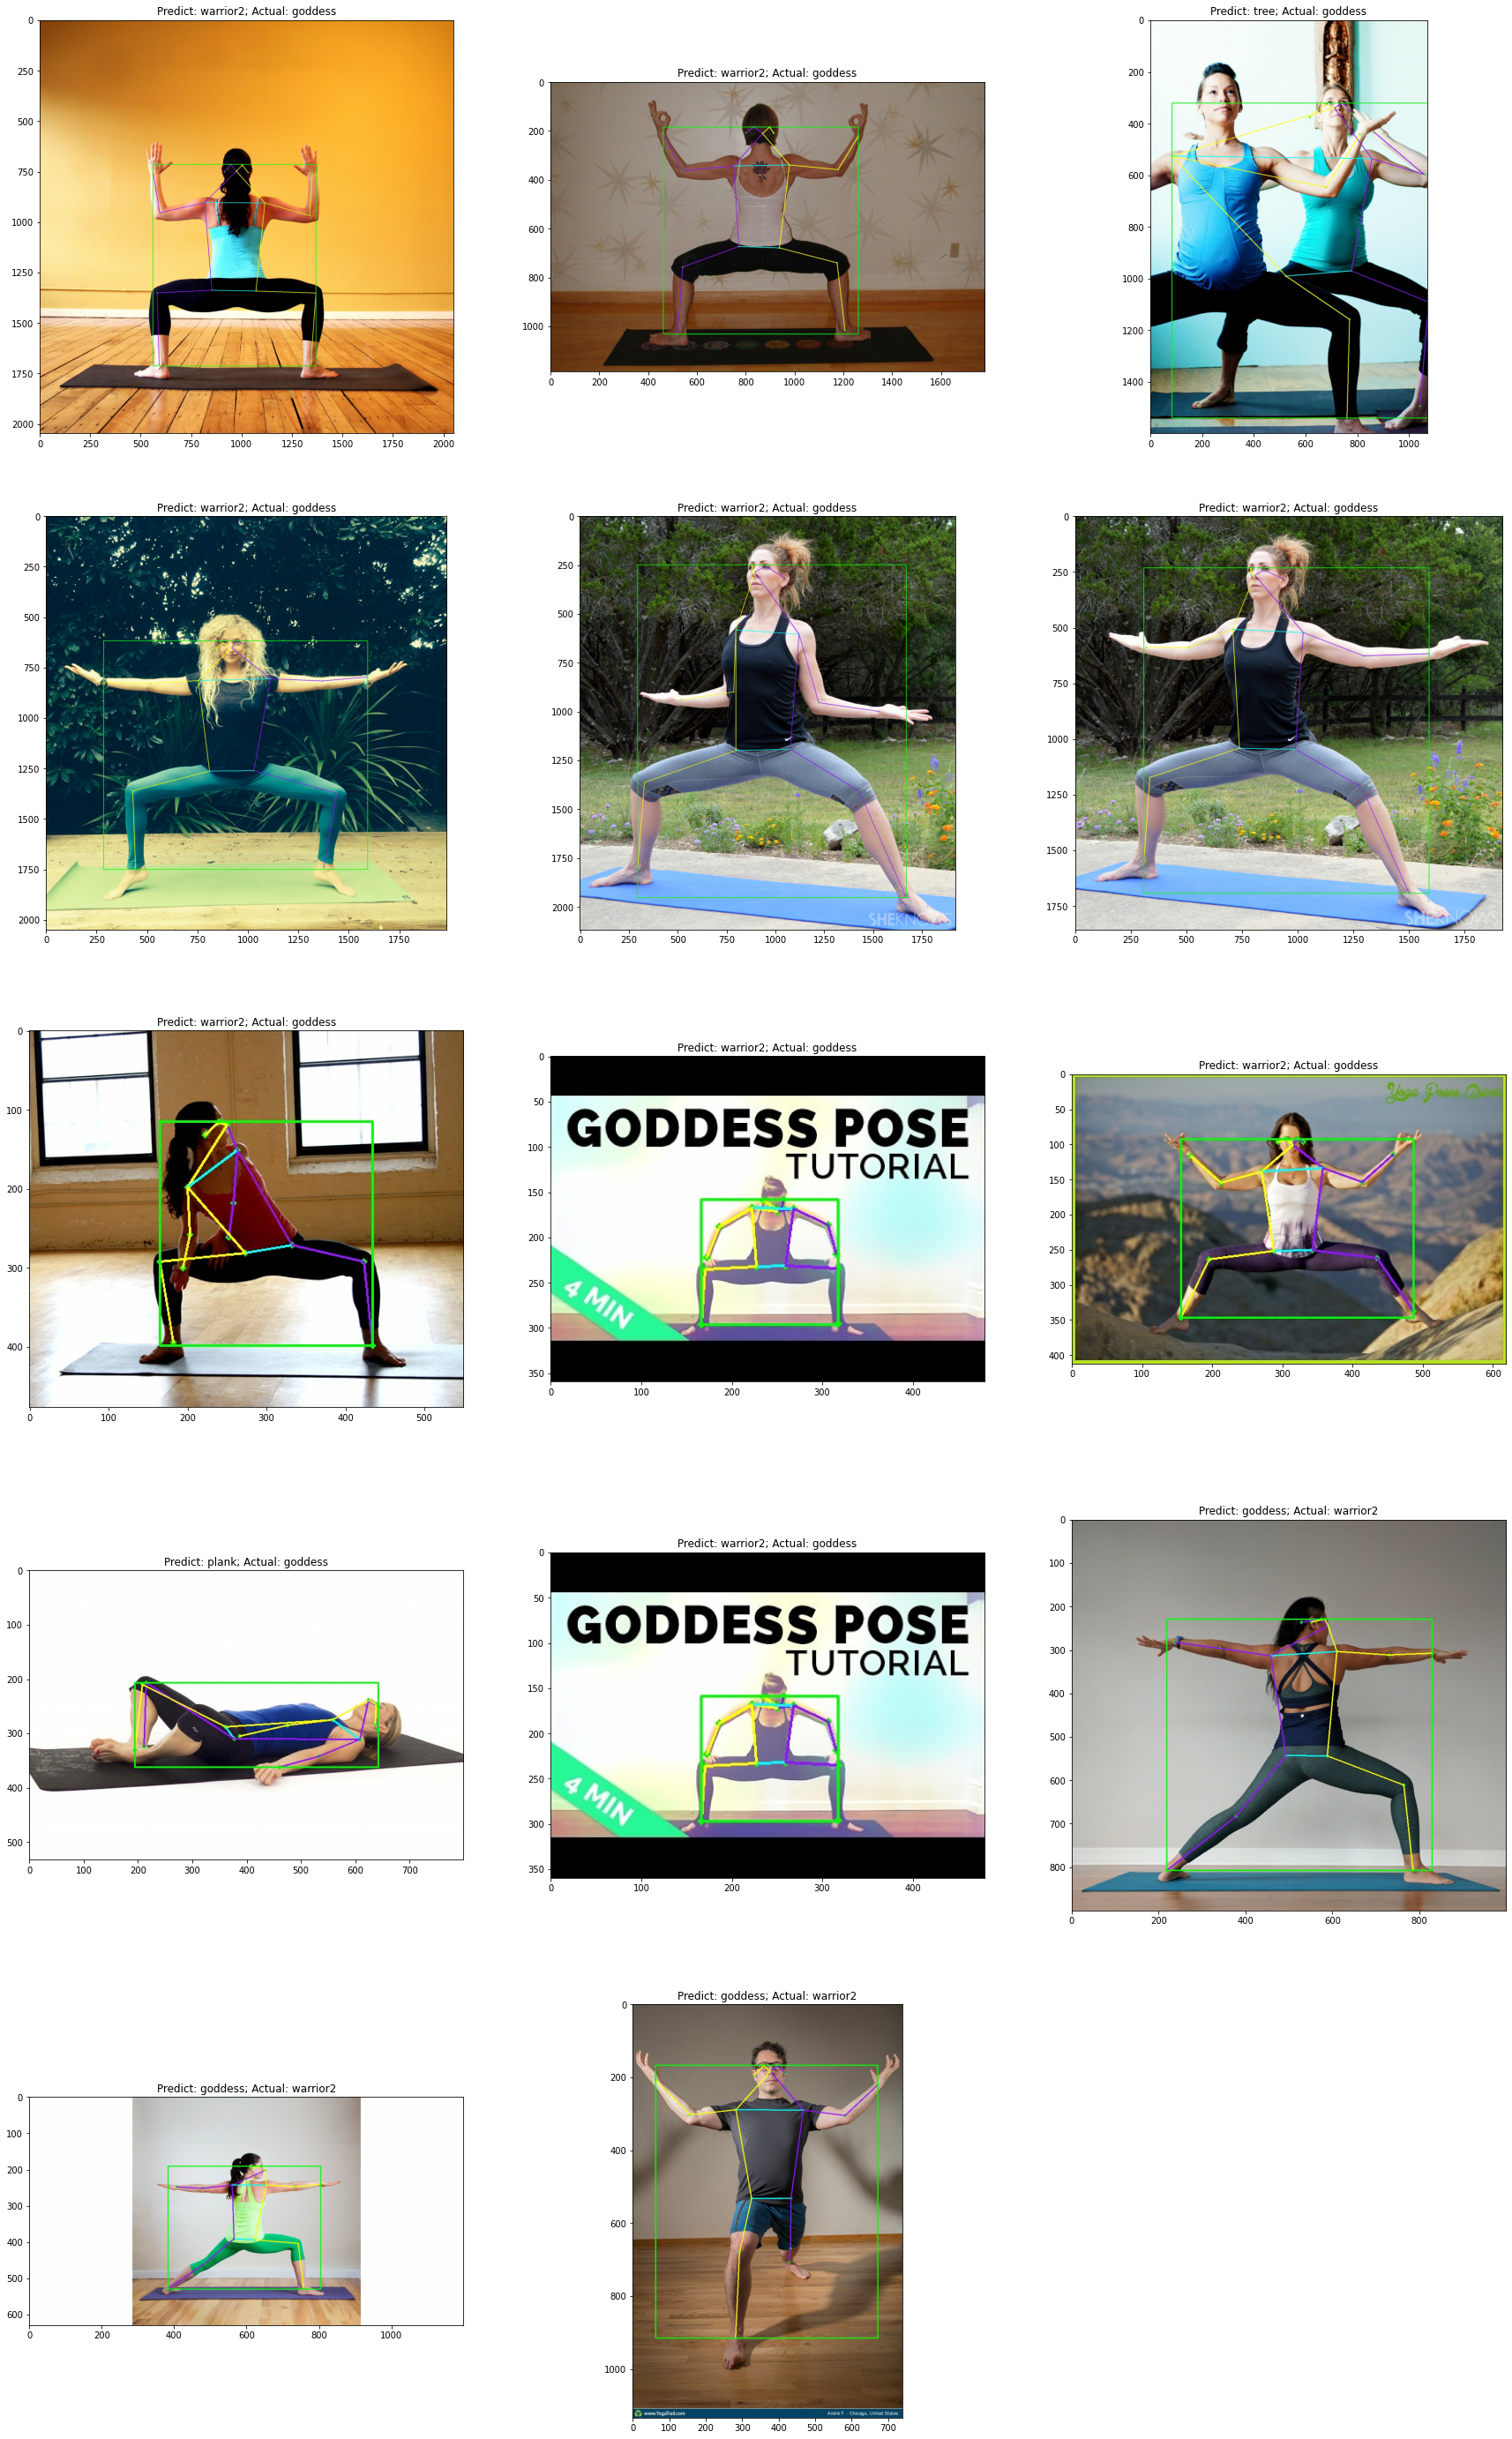

In [ ]:
IMAGE_PER_ROW = 3
MAX_NO_OF_IMAGE_TO_PLOT = 30

# Extract the list of incorrectly predicted poses
false_predict = [id_in_df for id_in_df in range(len(y_test)) \
                if y_pred_label[id_in_df] != y_true_label[id_in_df]]
if len(false_predict) > MAX_NO_OF_IMAGE_TO_PLOT:
  false_predict = false_predict[:MAX_NO_OF_IMAGE_TO_PLOT]

# Plot the incorrectly predicted images
row_count = len(false_predict) // IMAGE_PER_ROW + 1
fig = plt.figure(figsize=(10 * IMAGE_PER_ROW, 10 * row_count))
for i, id_in_df in enumerate(false_predict):
  ax = fig.add_subplot(row_count, IMAGE_PER_ROW, i + 1)
  image_path = os.path.join(images_out_test_folder,
                            df_test.iloc[id_in_df]['file_name'])

  image = cv2.imread(image_path)
  plt.title("Predict: %s; Actual: %s"
            % (y_pred_label[id_in_df], y_true_label[id_in_df]))
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

## Convert model to TensorFlow Lite
You'll convert the Keras pose classification model to the TensorFlow Lite format so that you can deploy it to mobile apps, web browsers and edge devices. When converting the model, you'll apply dynamic range quantization to reduce the pose classification TensorFlow Lite model size by about 4 times with insignificant accuracy loss.

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

print('Model size: %dKB' % (len(tflite_model) / 1024))

with open('pose_classifier.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpa377edbp/assets


Model size: 26KB


In [ ]:
with open('pose_labels.txt', 'w') as f:
  f.write('\n'.join(class_names))

In [ ]:
def evaluate_model(interpreter, X, y_true):
  """Evaluates the given TFLite model and return its accuracy."""
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on all given poses.
  y_pred = []
  for i in range(len(y_true)):
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = X[i: i + 1].astype('float32')
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the class with highest
    # probability.
    output = interpreter.tensor(output_index)
    predicted_label = np.argmax(output()[0])
    y_pred.append(predicted_label)

  # Compare prediction results with ground truth labels to calculate accuracy.
  y_pred = keras.utils.to_categorical(y_pred)
  return accuracy_score(y_true, y_pred)

# Evaluate the accuracy of the converted TFLite model
classifier_interpreter = tf.lite.Interpreter(model_content=tflite_model)
classifier_interpreter.allocate_tensors()
print('Accuracy of TFLite model: %s' %
      evaluate_model(classifier_interpreter, X_test, y_test))

Accuracy of TFLite model: 0.95662100456621


In [ ]:
!zip pose_classifier.zip pose_labels.txt pose_classifier.tflite

  adding: pose_labels.txt (stored 0%)
  adding: pose_classifier.tflite (deflated 35%)
